# Which version of the website should you use?

## 📖 Background
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

## 💪 Challenge
Complete the following tasks:

1. Analyze the conversion rates for each of the four groups: the new/old design of the landing page and the new/old pictures.
2. Can the increases observed be explained by randomness? (Hint: Think A/B test)
3. Which version of the website should they use?

# 🗺️ Designing the Test

In order to find out which version should be used, we first need to analyze our dataset. We already know that our control group are users with the old landing page and the old images; that means that we have 3 different treatment groups, which are users with the old landing page and the new images, the users with the new landing page and the old images, and lastly, the users with the new landing page and the new images. Since there is little information provided on how the data was collected, we will assume that the data is collected at random.

We can then calculate the conversion rates from each group to discover which group has the highest conversion rate and perform A/B Test for each treatment groups against the control group and prove if the difference in their conversion rates is statistically significant. The Null Hypothesis is that the control and treatment have the same impact on the response, and the Alternate Hypothesis is otherwise. The results will be visualized and compared for each treatment group and the best performer wins.

## 📋 The data
The team assembled the following file:

### Redesign test data
- "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
- "new_images" - "yes" if the page used a new set of images, no otherwise.
- "converted" - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('./data/redesign.csv')
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


### Handling Categories

In [3]:
df[['treatment','new_images']] = df[['treatment','new_images']].astype('category')
df.dtypes

treatment     category
new_images    category
converted        int64
dtype: object

### Handling Missing Values

In [4]:
df.isna().sum()

treatment     0
new_images    0
converted     0
dtype: int64

Since the data does not have user information, only the categories and missing values need to be taken care of. However, it doesn't look like there's any missing values, so what we can do to simplify the use of our dataset is by labelling our variants as such:
- Variant A: old landing page and old images (control group)
- Variant B: old landing page and new images
- Variant C: new landing page and old images
- Variant D: new landing page and new images

In [5]:
df['variant'] = np.where((df['treatment']=='no')&(df['new_images']=='no'), 'A',
                         np.where((df['treatment']=='no')&(df['new_images']=='yes'), 'B',
                                  np.where((df['treatment']=='yes')&(df['new_images']=='no'), 'C', 'D')))
df.head()

,treatment,new_images,converted,variant
0,yes,yes,0,D
1,yes,yes,0,D
2,yes,yes,0,D
3,yes,no,0,C
4,no,yes,0,B


# 📈 Conversion Rates

In this section, we will calculate the conversion rates for each group. Our dataset is already simplified and has a dedicated column of whether or not the user converted, so we can jump straight into calculating the conversion rate for each group, which essentially is the sum of users converted and the total number of users in the group.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', font_scale=1.25, context='notebook', palette='bright')

In [7]:
def diff(x):
    return len(x) - x.sum()
def rate(x):
    return x.sum() / x.count()

In [8]:
g = df.groupby(['variant']).converted.agg(['sum',diff,'count',rate])
g.columns = ['converted','not converted','count','convert rate']
g

,converted,not converted,count,convert rate
variant,,,,
A,1084,9037,10121,0.107104
B,1139,8982,10121,0.112538
C,1215,8906,10121,0.120047
D,1151,8970,10121,0.113724


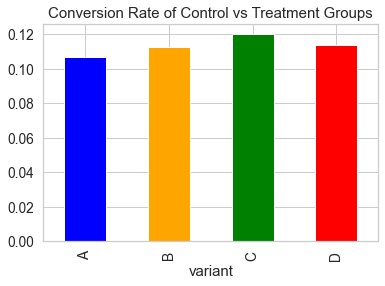

In [9]:
g.plot(kind='bar', y='convert rate',  legend=False, color=['blue','orange','green','red'])
plt.title('Conversion Rate of Control vs Treatment Groups')
plt.show()

In [10]:
boot = []
for i in range(11000):
    boot_mean = df.sample(frac=1, replace=True).groupby(['variant'])['converted'].mean()
    boot.append(boot_mean)

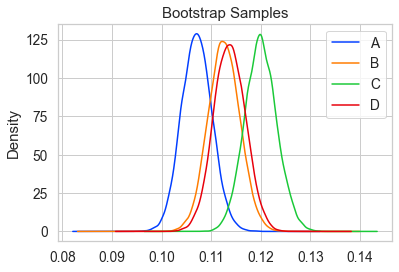

In [11]:
boot = pd.DataFrame(boot)

boot.plot(kind='kde', legend=False)
plt.title('Bootstrap Samples')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Based on the grouped data, we know that each group has the same number of users assigned. From the figures above, we clearly see that on particular group performs better than the rest, which is the group of users with the new landing page and old images. However, we also see that the two other treatment groups perform better than the control group. In attempt to ascertain the performance over the control group, we plotted the bootstrap uncertainty of each group above. Note that the control group is the blue line, and we see that the green line (the new landing page and old images) barely overlaps the control group, while the orange and red overlaps with the control group for the most part.

# ⛔ Difference in the Rates

To further observe the difference between the control group and the treatment groups, we can subtract the bootstrap samples between the control group and the treatment groups.

In [12]:
boot['diff_a_b'] = 100 * ((boot['B'] - boot['A']) / boot['B'])
boot['diff_a_c'] = 100 * ((boot['C'] - boot['A']) / boot['C'])
boot['diff_a_d'] = 100 * ((boot['D'] - boot['A']) / boot['D'])

In [13]:
boot.head()

variant,A,B,C,D,diff_a_b,diff_a_c,diff_a_d
converted,0.109788,0.108646,0.120977,0.115621,-1.051659,9.248638,5.044736
converted,0.108360,0.107371,0.123886,0.115974,-0.921884,12.532211,6.564755
converted,0.104355,0.108214,0.117856,0.111632,3.566061,11.455801,6.518663
converted,0.107621,0.114083,0.119525,0.114446,5.663813,9.959067,5.963394
converted,0.106007,0.109282,0.120470,0.113131,2.997119,12.005806,6.297135


In [14]:
print('% difference in means of A and B :', boot['diff_a_b'].mean())
print('% difference in means of A and C :', boot['diff_a_c'].mean())
print('% difference in means of A and D :', boot['diff_a_d'].mean())

% difference in means of A and B : 4.806963079762475
% difference in means of A and C : 10.686076809789796
% difference in means of A and D : 5.741783940106996


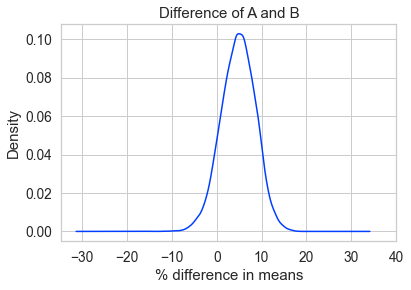

In [15]:
plt.title('Difference of A and B')
boot['diff_a_b'].plot(kind='kde')
plt.xlabel("% difference in means")
plt.xticks(np.arange(-30, 45, 10))
plt.show()

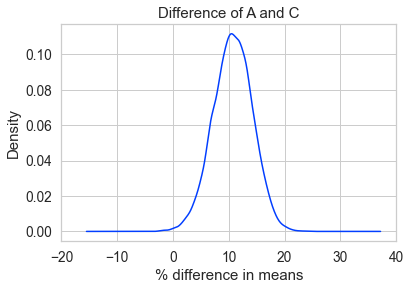

In [16]:
plt.title('Difference of A and C')
boot['diff_a_c'].plot(kind='kde')
plt.xlabel("% difference in means")
plt.xticks(np.arange(-20, 45, 10))
plt.show()

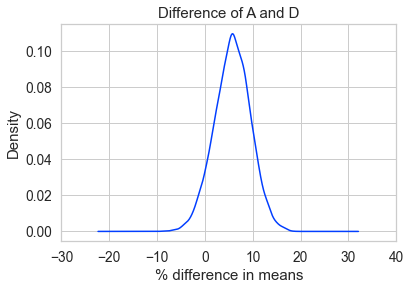

In [17]:
plt.title('Difference of A and D')
boot['diff_a_d'].plot(kind='kde')
plt.xlabel("% difference in means")
plt.xticks(np.arange(-30, 45, 10))
plt.show()

# 🤔 Hypothesis Testing

By eyeballing the graphs and the values from the table above, we see that that there is a distinct difference between the conversion rates of control group and the treatment groups. However, to prove if the groups' differences are statistically significant, we will conduct hypothesis tests, where we set the Null and Alternate Hypothesis as such:
- Null Hypothesis : the control and treatment group have the same impact on the response
- Alternate Hypothesis : the control and treatment group does not have the same impact on the response

Furthermore, we set the confidence level to 95% to set the probability of rejecting Type I errors, and after the tests, we evaluate the statistical power of the test to see the probability of rejecting Type II errors.

In [18]:
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [19]:
def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    qu = stats.norm.ppf(1 - alpha/2)    
    diff = abs(p2 - p1)   
    bp = (p1 + p2) / 2   
    v1 = p1 * (1 - p1)  
    v2 = p2 * (1 - p2)   
    bv = bp * (1 - bp)    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)   
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)  
    power = power_part_one + power_part_two    
    return(power)

In [20]:
def test_pvalue(p):
    if p < 0.01:
        s = 'Very strong evidence against Null Hypothesis'
    elif p < 0.05:
        s = 'Strong evidence against Null Hypothesis'
    elif p < 0.1:
        s = 'Very weak evidence against Null Hypothesis'
    else:
        s = 'Small to no evidence against Null Hypothesis'
    return s

### Old Landing Page, Old Images

In [21]:
con_conv = g['convert rate']['A']
con_size = g['count']['A']
con_results = g['converted']['A']

### Old Landing Page, New Images

In [22]:
test_conv = g['convert rate']['B']
test_size = g['count']['B']
test_results = g['converted']['B']

In [23]:
alpha = 0.05
successes = [con_results, test_results]
nobs = [con_size, test_size]
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_test), (upper_con, upper_test) = proportion_confint(successes, nobs=nobs, alpha=alpha)
power = get_power(test_size, con_conv, test_conv, 1-alpha)
print('Z-Statistic'+ (':').rjust(15) + f' {z_stat:.4f}') 
print('p-value'+ (':').rjust(19) + f' {p_value:.4f}')
print('Power of test'+ (':').rjust(13) +f' {100*power:.2f}%')
print(f'ci {100*(1-alpha):.0f}% for control group : [{lower_con:.4f}, {upper_con:.4f}]')
print(f'ci {100*(1-alpha):.0f}% for test group    : [{lower_test:.4f}, {upper_test:.4f}]')
test_pvalue(p_value)

Z-Statistic              : -1.2364
p-value                  : 0.2163
Power of test            : 23.53%
ci 95% for control group : [0.1011, 0.1131]
ci 95% for test group    : [0.1064, 0.1187]


'Small to no evidence against Null Hypothesis'

### New Landing Page, Old Images

In [24]:
test_conv = g['convert rate']['C']
test_size = g['count']['C']
test_results = g['converted']['C']

In [25]:
alpha = 0.05
successes = [con_results, test_results]
nobs = [con_size, test_size]
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_test), (upper_con, upper_test) = proportion_confint(successes, nobs=nobs, alpha=alpha)
power = get_power(test_size, con_conv, test_conv, 1-alpha)
print('Z-Statistic'+ (':').rjust(15) + f' {z_stat:.4f}') 
print('p-value'+ (':').rjust(19) + f' {p_value:.4f}')
print('Power of test'+ (':').rjust(13) +f' {100*power:.2f}%')
print(f'ci {100*(1-alpha):.0f}% for control group : [{lower_con:.4f}, {upper_con:.4f}]')
print(f'ci {100*(1-alpha):.0f}% for test group    : [{lower_test:.4f}, {upper_test:.4f}]')
test_pvalue(p_value)

Z-Statistic              : -2.9019
p-value                  : 0.0037
Power of test            : 82.69%
ci 95% for control group : [0.1011, 0.1131]
ci 95% for test group    : [0.1137, 0.1264]


'Very strong evidence against Null Hypothesis'

### New Landing Page, New Images

In [26]:
test_conv = g['convert rate']['D']
test_size = g['count']['D']
test_results = g['converted']['D']

In [27]:
alpha = 0.05
successes = [con_results, test_results]
nobs = [con_size, test_size]
z_stat, p_value = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_test), (upper_con, upper_test) = proportion_confint(successes, nobs=nobs, alpha=alpha)
power = get_power(test_size, con_conv, test_conv, 1-alpha)
print('Z-Statistic'+ (':').rjust(15) + f' {z_stat:.4f}') 
print('p-value'+ (':').rjust(19) + f' {p_value:.4f}')
print('Power of test'+ (':').rjust(13) +f' {100*power:.2f}%')
print(f'ci {100*(1-alpha):.0f}% for control group : [{lower_con:.4f}, {upper_con:.4f}]')
print(f'ci {100*(1-alpha):.0f}% for test group    : [{lower_test:.4f}, {upper_test:.4f}]')
test_pvalue(p_value)

Z-Statistic              : -1.5026
p-value                  : 0.1329
Power of test            : 32.40%
ci 95% for control group : [0.1011, 0.1131]
ci 95% for test group    : [0.1075, 0.1199]


'Small to no evidence against Null Hypothesis'

| Variant                  | User Count | Converted | Conversion Rate | Confidence Interval | Z-Statistic | P-Value | Power  |
|------------------------------|------------|-----------|-----------------|---------------------|-------------|---------|--------|
| Old Landing Page, Old Images ('A') | 10121      | 1084      | 0.1071          | [0.1011, 0.1131]    |             |         |        |
| Old Landing Page, New Images ('B') | 10121      | 1139      | 0.1125          | [0.1064, 0.1187]    | -1.2364     | 0.2163  | 23.55% |
| **New Landing Page, Old Images ('C')** | 10121      | **1215**      | **0.1200**          | **[0.1137, 0.1264]**    | **-2.9019**     | **0.0037**  | **82.69%** |
| New Landing Page, New Images ('D') | 10121      | 1151      | 0.1137          | [0.1075, 0.1199]    | -1.5026     | 0.1329  | 32.40% |

# 🥇 Winner by Unanimous Decision!

Based on the test results, we conclude that the best website version is:

- **Variant C: New Landing Page with Old Images**

It is the only variant with a p-value below our significance level (0.05), strongly rejecting the Null Hypothesis. Moreover, it has a statistical power of 82.69% to reject false negatives. To explain the results, the old landing page was the only issue about the website, and the new landing page on its own was enough to resolve conversion rate, while the old images needed no changes.

## 🔮 Future Works

- Determine if the users were randomly assigned to each group to verify integrity of test.
- Set test sensitivity as to also determine the sample size needed to conduct the tests.
- Further analyze why the new landing page performs better and why the new images were not helping.